In [1]:
import sys
sys.path.append("../../src")

import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from utils.kernel_utils import ColumnwiseRBF, RBF
from causal_models.proxy_causal_learning import KernelNegativeControlATT
from generate_experiment_data import generate_synthetic_data

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
data_size = 1000
seed = 47
np.random.seed(seed)

U, W, Z, A, Y, do_A, EY_do_A = generate_synthetic_data(size = data_size, seed = seed)

W, Z, A, Y, do_A, EY_do_A = jnp.array(W), jnp.array(Z), jnp.array(A), jnp.array(Y), jnp.array(do_A), jnp.array(EY_do_A)

train_data_perc = 1.0
test_data_perc = 1 - train_data_perc

indices = np.random.permutation(A.shape[0])
train_data_size = int(A.shape[0] * train_data_perc)
training_idx, test_idx = indices[:train_data_size], indices[train_data_size:]

A_train, Y_train, W_train, Z_train = A[training_idx], Y[training_idx], W[training_idx], Z[training_idx]

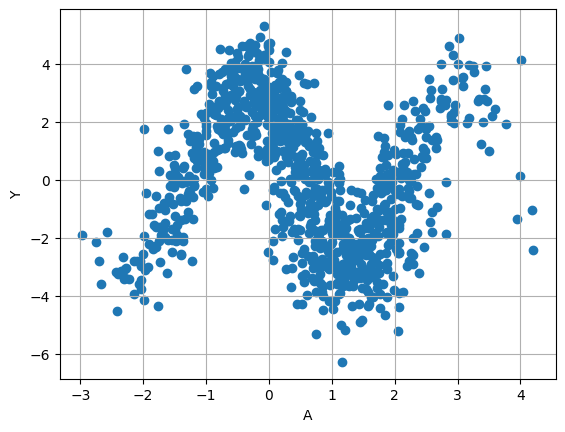

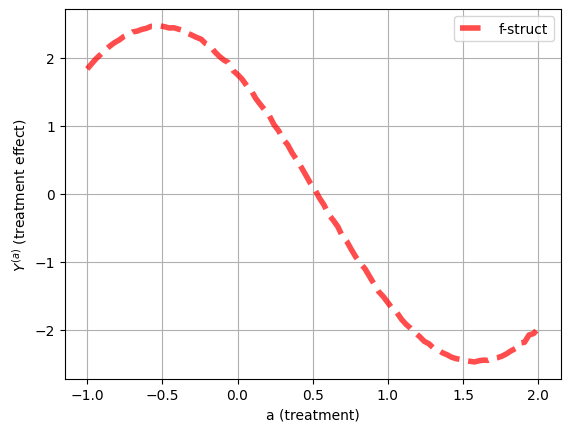

In [4]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()

In [5]:
RBF_Kernel_Z = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_W = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_A = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_X = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)

lambda_ = 1e-3
zeta = 1*1e-3
lambda2 = 1e-3
optimize_regularization_parameters = True
lambda_optimization_range = (1e-9, 1.0)
zeta_optimization_range = (1e-9, 1.0)
stage1_perc = 0.5
regularization_grid_points = 150

model = KernelNegativeControlATT(
                                 kernel_A = RBF_Kernel_A,
                                 kernel_W = RBF_Kernel_W,
                                 kernel_Z = RBF_Kernel_Z,
                                 kernel_X = RBF_Kernel_X,
                                 lambda_ = lambda_,
                                 zeta = zeta, 
                                 lambda2 = lambda2,
                                 optimize_regularization_parameters = optimize_regularization_parameters,
                                 lambda_optimization_range = lambda_optimization_range,
                                 zeta_optimization_range = zeta_optimization_range,
                                )

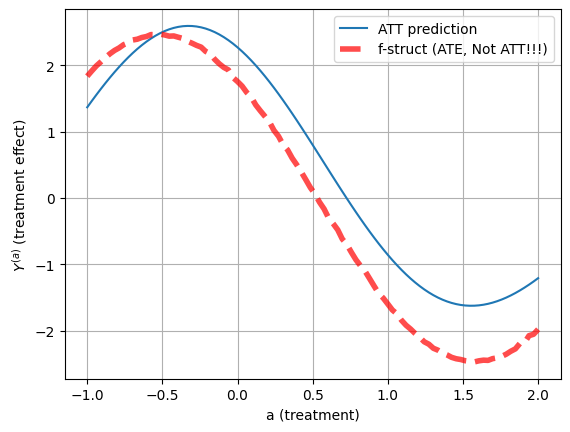

In [6]:
model.fit((A, W, Z), Y)

aprime = jnp.array([-1.5])
f_struct_pred = model.predict(do_A, aprime)


plt.plot(do_A, f_struct_pred, label = "ATT prediction")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha = 0.7, linestyle = "dashed", label = "f-struct (ATE, Not ATT!!!)")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()

In [7]:
model.lambda_, model.zeta, model.lambda2

(Array(0.00582238, dtype=float64),
 Array(0.01015574, dtype=float64),
 Array(0.00768964, dtype=float64))